The precision of the neural network model deteriorates with time and its optimal performance is observed immediately after it has undergone training.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES
from ficc.utils.nelson_siegel_model import yield_curve_level
from ficc.utils.diff_in_days import diff_in_days_two_dates
from ficc.utils.auxiliary_variables import NUM_OF_DAYS_IN_YEAR


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/gil/git/ficc/creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Creating big query and GCP storage client

In [3]:
bq_client = bigquery.Client()
storage_client = storage.Client()

Declaring hyper-parameters

In [4]:
BATCH_SIZE = 1000
SEQUENCE_LENGTH = 5
NUM_FEATURES = 6

### Creating test set

In [5]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('ahmad_data/processed_data.pkl') as f:
    data = pd.read_pickle(f)

In [6]:
data.trade_date.min ()

Timestamp('2022-07-01 00:00:00')

Here is a list of exclusions that we will be experimenting with. The model is trained with these exclusions.
<ul>
    <li>Callable less than a year in the future </li>
    <li>Maturity less than a year in the future and more than 30 years in the future</li>
<ul>

In [7]:
# data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
# data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
# data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
# data = data[data.days_to_maturity < np.log10(30000)]

#### Adding features for training

In [8]:
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

In [9]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')

In [10]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     'trade_history_sum',
                     'new_ficc_ycl',
                     'days_to_refund',
                     'is_called']

In [11]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]# + ['target_attention_features','yield_spread']]

In [12]:
len(processed_data)

6284349

In [13]:
processed_data['new_ys'] = processed_data['yield'] - processed_data['new_ficc_ycl']

Isolating data to test models

In [14]:
test_dataframe = processed_data[(processed_data.trade_date >= '01-01-2023') & (processed_data.trade_date <= '02-09-2023') ]

Converting data into format suitable for the model

In [15]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('ahmad_data/encoders_2023-02-07-21-29.pkl') as f:
    encoders = pd.read_pickle(f)

In [16]:
encoders

{'rating': LabelEncoder(),
 'incorporated_state_code': LabelEncoder(),
 'trade_type': LabelEncoder(),
 'purpose_class': LabelEncoder()}

In [17]:
def create_input(df, encoders):
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [25]:
test_dataframe=test_dataframe[test_dataframe.rating != 'CC']

In [26]:
%%time
x_test = create_input(test_dataframe, encoders)

CPU times: user 1.75 s, sys: 140 ms, total: 1.89 s
Wall time: 1.89 s


### Measuring accuracy of New Yield Spread model

In [27]:
from scipy import stats

def mkeasy(df):
    df = df[df.trade_type != "P"]
    df = df[df.quantity > np.log10(1e5 - 1)]
    # df = df[df.last_size > np.log10(3e5 - 1)]
    # df = df[df.federal_tax_status != 3]
    # df = df[~df.par_issue]
    # df = df[df.mindays > 180]
    df = df[df.trade_datetime != pd.to_datetime("2022-11-29T16:00:14")]
    return df.copy()

def dailyskew(df, feat='coupon', val='all', metric='error', month=0):
    if month > 0: df = df[df.month == month]
    z = np.nan_to_num( stats.zscore(df[metric], nan_policy='omit'), 99)
    df = df[np.abs(z) < 9]
    other = df[df[feat] != val]
    otherdaily = other.groupby('trade_date')[metric]
    if val == 'all':
        skew = otherdaily.mean()
        delta = 2 * otherdaily.std() / np.sqrt( otherdaily.count() )
    else:
        these = df[df[feat] == val]
        thesedaily = these.groupby('trade_date')[metric]
        skew = thesedaily.mean() - otherdaily.mean()
        delta = otherdaily.std() / np.sqrt( otherdaily.count() ) + thesedaily.std() / np.sqrt( thesedaily.count() )
    avg = skew.mean()
    print( f"mean {avg:5.2f} +/- {skew.std():4.2f}  autocorr {skew.autocorr():4.2f}" )
    plt.figure(figsize=(12,4))
    plt.errorbar(x=skew.index, y=skew, yerr=delta, fmt='bo')

In [28]:
def calculate_mae(df,column_1, column_2):
    print(f"Number of samples: {len(df)}")
    return np.mean(np.abs(df[column_1] - df[column_2]))

Loading ys model

In [29]:
new_ys_model = keras.models.load_model('new_ys_model')

In [30]:
dates = []
mae = []

In [31]:
for d in [d for d in pd.date_range(start="01/01/2023",end="09/09/2023",freq='D')]:
    single_day = test_dataframe[(test_dataframe.trade_date == d)].copy()
    if len(single_day) == 0:
        continue
    day_test = create_input(single_day, encoders)  
    day_preds = new_ys_model.predict(day_test)
    error = single_day.yield_spread - day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    dates.append(d.date())
    mae.append(MAE)
    print(f"Date :{d.date()} MAE:{MAE}" )

Date :2023-01-03 MAE:14.03625223295972
Date :2023-01-04 MAE:14.576886837450088
Date :2023-01-05 MAE:17.535803097286504
Date :2023-01-06 MAE:15.485699664874423
Date :2023-01-09 MAE:17.797269410781716
Date :2023-01-10 MAE:16.413267628788766
Date :2023-01-11 MAE:16.062070232794266
Date :2023-01-12 MAE:16.557489466477264
Date :2023-01-13 MAE:16.79730486360286
Date :2023-01-17 MAE:17.856996267161957
Date :2023-01-18 MAE:17.508891170668548
Date :2023-01-19 MAE:16.80539989647414
Date :2023-01-20 MAE:16.787267361687224
Date :2023-01-23 MAE:17.055387720752023
Date :2023-01-24 MAE:15.46892761916529
Date :2023-01-25 MAE:16.429992241663264
Date :2023-01-26 MAE:18.18900357300107
Date :2023-01-27 MAE:15.98415004401445
Date :2023-01-30 MAE:16.508008100047704
Date :2023-01-31 MAE:16.072752371735348
Date :2023-02-01 MAE:16.27484386237278
Date :2023-02-02 MAE:17.396310605983537
Date :2023-02-03 MAE:17.972433940667116
Date :2023-02-06 MAE:18.581959639778628


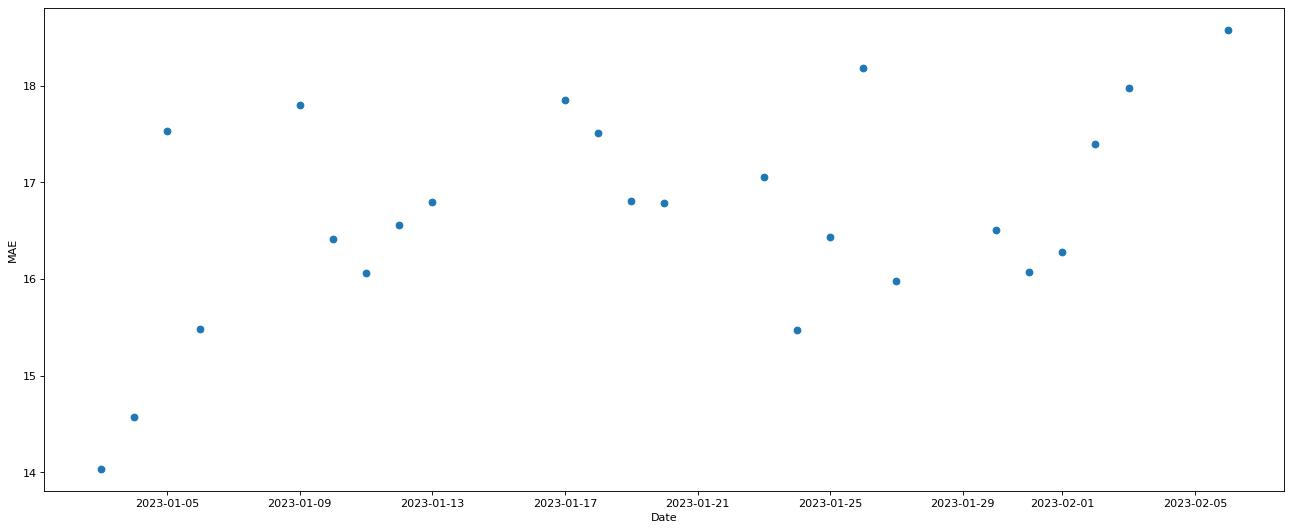

In [32]:
plt.figure(figsize=(20, 8), dpi=80)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.scatter(dates, mae)

In [33]:
ys_predictions = new_ys_model.predict(x_test, batch_size=BATCH_SIZE)

In [34]:
test_dataframe['predicted_ys'] = ys_predictions

mean 16.20 +/- 1.15  autocorr 0.85


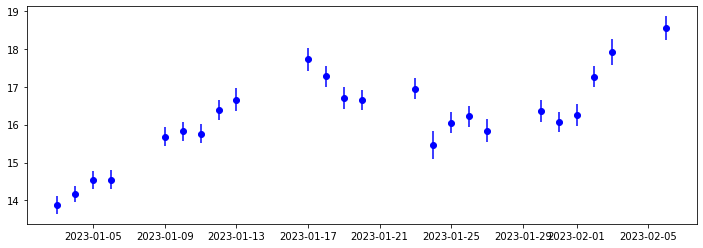

In [35]:
test_dataframe['error'] = np.abs(test_dataframe.yield_spread - test_dataframe.predicted_ys)
dailyskew(test_dataframe)

mean 13.75 +/- 0.97  autocorr 0.59


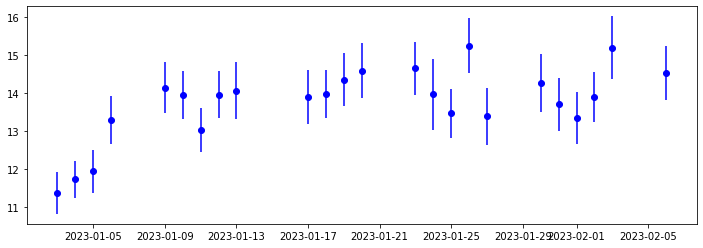

In [36]:
dailyskew(mkeasy(test_dataframe))

In [37]:
test_dataframe['delta'] = test_dataframe['yield_spread'] - test_dataframe['predicted_ys']

In [38]:
test_dataframe['predicted_ytw'] = test_dataframe['new_ficc_ycl'] + test_dataframe['predicted_ys']

In [ ]:
test_dataframe[['new_ficc_ycl','predicted_ys','calc_date','predicted_ytw']]

Yiels Spread MAE increase over time: 

In [41]:
for d in [d for d in pd.date_range(start="01/01/2023",end="09/09/2023",freq='D')]:
    single_day = test_dataframe[(test_dataframe.trade_date == d)].copy()
    if len(single_day) == 0:
        continue
    
    error = single_day['yield'] - single_day.predicted_ytw
    MAE = np.mean(np.abs(error))
    dates.append(d.date())
    mae.append(MAE)
    print(f"Date :{d.date()} MAE:{MAE}" )
    
#calculate_mae(test_dataframe,'new_ys', 'predicted_ys')

Date :2023-01-03 MAE:11.5634686458203
Date :2023-01-04 MAE:12.24957119161128
Date :2023-01-05 MAE:15.07942442078721
Date :2023-01-06 MAE:12.597906369756293
Date :2023-01-09 MAE:14.667864185182516
Date :2023-01-10 MAE:13.135786935659318
Date :2023-01-11 MAE:12.871961508619925
Date :2023-01-12 MAE:12.61738048400541
Date :2023-01-13 MAE:13.209699594712953
Date :2023-01-17 MAE:14.160016834409522
Date :2023-01-18 MAE:13.547071693396825
Date :2023-01-19 MAE:13.132026370762604
Date :2023-01-20 MAE:12.936867916934219
Date :2023-01-23 MAE:13.14923857609828
Date :2023-01-24 MAE:11.673263701302565
Date :2023-01-25 MAE:12.678188232388385
Date :2023-01-26 MAE:14.042214279347538
Date :2023-01-27 MAE:12.145311863696302
Date :2023-01-30 MAE:12.795193979789978
Date :2023-01-31 MAE:12.432673263414664
Date :2023-02-01 MAE:12.539384128427853
Date :2023-02-02 MAE:13.491924208620084
Date :2023-02-03 MAE:13.467020323300098
Date :2023-02-06 MAE:14.285268775700368
Number of samples: 866059


13.125794424563864

mean 12.62 +/- 0.72  autocorr 0.64


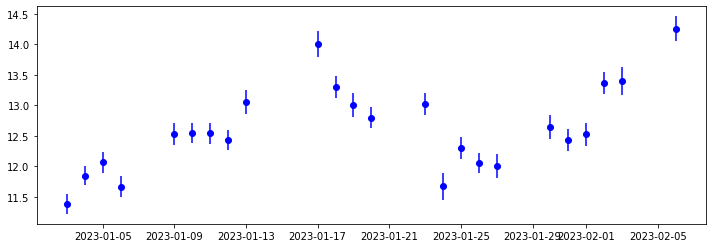

In [44]:
test_dataframe['YTW_error'] = np.abs(test_dataframe['yield'] - test_dataframe.predicted_ytw)
dailyskew(test_dataframe,metric="YTW_error")

Yield to worst MAE

In [ ]:
calculate_mae(test_dataframe,'yield','predicted_ytw')

Yield to worst MAE when using get_calc_date to estimate calc date

In [ ]:
large_dealer_dealer_trades = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
calculate_mae(large_dealer_dealer_trades, 'yield_spread', 'predicted_ys')